# Aim

Solve an LQR toy problem to see what to do

In [1]:
import numpy as np
from scipy import linalg as la
from scipy import stats as st
from matplotlib import pyplot as plt

inv = np.linalg.inv
mvn = st.multivariate_normal
rms = lambda data: round(np.sqrt(np.mean((data - np.mean(data)) ** 2)), 4)

In [2]:
import sys
sys.path.append("..")
from src.controllers import KalmanLQG

Running in simulation mode.
Recomputed interaction matrix and command matrix


/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:109: UserWarning: Exposure time in sim optics is not used yet.
  warnings.warn("Exposure time in sim optics is not used yet.")
/Users/adityasengupta/research/ao/set-tt-control/notebooks/../src/optics/image.py:117: UserWarning: Image propagation from the DM has not been implemented.
  warnings.warn("Image propagation from the DM has not been implemented.")


In [3]:
s = 2
m = 1
p = 1
nsteps = 1000

In [51]:
A = np.array([[0.94154541, -0.97488067], [1, 0]])
B = np.random.randn(s,m)
C = np.random.randn(p,s)
Q = np.eye(s)
R = 1e-4 * np.eye(m)
W = np.eye(s)
V = 0.0036 * np.eye(p)
klv = KalmanLQG(A, B, C, W, V, Q, R)
process_dist = mvn(cov=W)
measure_dist = mvn(cov=V)
x = process_dist.rvs()

Solved discrete ARE.
Solved discrete ARE.


In [52]:
states_un = np.zeros((nsteps, s))
states_un[0,:] = x
for i in range(1, nsteps):
    states_un[i,:] = A @ states_un[i-1,:] + process_dist.rvs()
    
rms(states_un @ C.T)

4.64

In [53]:
states_nokf = np.zeros((nsteps, s))
states_nokf[0,:] = x
for i in range(1, nsteps):
    x = states_nokf[i-1,:]
    u = klv.L @ x
    states_nokf[i,:] = A @ x + B @ u + process_dist.rvs()
    
rms(states_nokf @ C.T)

1.0482

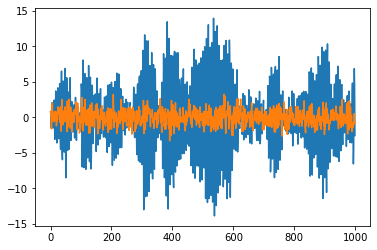

In [54]:
plt.plot(states_un @ C.T)
plt.plot(states_nokf @ C.T)

In [55]:
states = np.zeros((nsteps, s))
states_hat = np.zeros((nsteps, s))
states[0,:] = x
states_hat[0,:] = x
for i in range(1, nsteps):
    x = states[i-1,:]
    x_hat = states_hat[i-1,:]
    u = klv.L @ x_hat
    y = C @ (A @ x + B @ u) + measure_dist.rvs()
    innovation = y - C @ (A @ x_hat + B @ u)
    states[i,:] = A @ x + B @ u + process_dist.rvs()
    states_hat[i,:] = A @ x_hat + B @ u + klv.K @ innovation
    
rms(states @ C.T)

1.4897

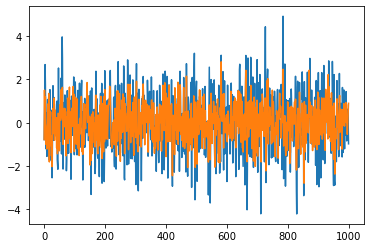

In [46]:
plt.plot(states @ C.T)
plt.plot(states_hat @ C.T)

In [50]:
np.std((states - states_hat) @ C.T)

1.013743739823095